In [101]:
# Zach Quinn
# DSC 550 
# 5 August 2020
# Final Project 
# File description: A fake news classification project using various ML classifiers on an assembled ML model.  
# File function: An exploration of the effectiveness of existing classifiers on an ML model for detecting text-based fake news.

In [5]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from yellowbrick.classifier import ClassificationReport
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

# And Now, The Fake News: 
# Comparing The Efficacy of Four Classifiers in Determining Whether or Not A Given Article Is Real or Fake News

### The purposeful spread of disinformation is one of the greatest threats to human society inflaming existing tensions, widening socioeconomic gaps and inciting physical violence. 

### Due to the nuance and variability of the human language, classification problems are among the hardest ML models to train and assess. 

### This project will attempt to build and assess a model that can predict fake news from an open source data set. 

# Hypothesis: Given its ubquity as a text classifier, a multinomial Naive Bayes classification algorithm will be best-suited to determine if a story is true or false.

# Null hypothesis: Naive Bayes will not be the most effective classifier for this problem.

In [6]:
# Read data from flat CSV file. 
fake_news = pd.read_csv('train.csv')

In [7]:
# Column values:

# ID = index ID, title = article title, author = source, text = document text. 
# Label = Binary label. 0 = True, 1 = False.

# Display first five rows. 
fake_news.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [8]:
# Get shape of the data - 20,800 observations in 5 columns. 
fake_news.shape

(20800, 5)

In [9]:
# Determine number of NA values in each column. 
fake_news.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [10]:
# Create clean data set with dropped NA values to avoid misclassification. 
fake_news_clean = fake_news.dropna()

In [11]:
# Check to ensure NA values are excluded. 
fake_news_clean.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [12]:
# Generate new shape for clean data set. 
fake_news_clean.shape

(18285, 5)

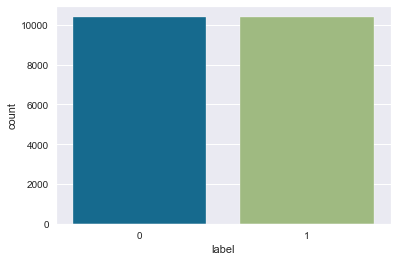

In [13]:
# Visualize ratio of true to false stories. 
sns.set_style('darkgrid')
sns.countplot(fake_news.label)

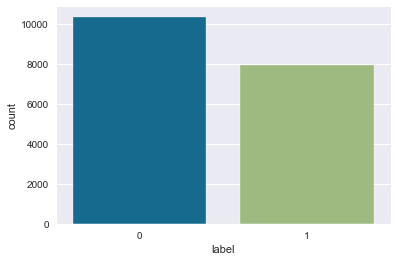

In [14]:
# Plot new ratio of true to false. Now, the true stories outweigh the false stories. 
sns.set_style('darkgrid')
sns.countplot(fake_news_clean.label)

In [15]:
# Isolate 'label' column to use as target variable.  
y = fake_news_clean['label']
fake_news_clean.drop('label', axis=1)

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...
...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal..."


In [16]:
# Create train-test split. Used 67/33 split to create more equitable partition of data given number of stories. 

X_train, X_test, y_train, y_test = train_test_split(fake_news_clean['text'], y, test_size = 0.33, random_state = 53)

In [17]:
# Initialize a count vectorizer to assess occurrences of words using default stop words parameter. 
count_vectorizer = CountVectorizer(stop_words = 'english')

In [18]:
# Transform count training data set into vector. 
fake_real_count_train = count_vectorizer.fit_transform(X_train)

In [19]:
# Transofmr count test set into vector. 
fake_real_count_test = count_vectorizer.transform(X_test)

In [20]:
# Initialize TFIDF vectorizer to assess word frequency. Use default English stop word parameters. 
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_df = 0.7)

In [21]:
# Transform X train data set into vectorized text.
fake_real_tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [22]:
# Transform X test data set into vectorized text. 
fake_real_tfidf_test = tfidf_vectorizer.transform(X_test)

In [97]:
# Create function to plot confusion matrix for Passive Aggressive Classifier. 
def plot_confusion_matrix(cm, classes, normalize=False, title = 'Passive Aggressive Classifier', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(f'Accuracy: {round(score*100,2)}%')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [98]:
# Initialize Passive Aggressive Classifier object with default max_iter value. 

linear_clf = PassiveAggressiveClassifier(max_iter = 50)

Confusion matrix, without normalization
Accuracy: 96.07%


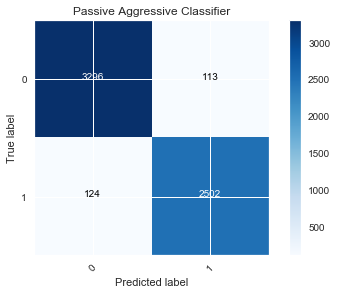

In [99]:
# Predict number of true positives vs. false negatives on vectorized test set to visualize confusion matrix. 
linear_clf.fit(fake_real_tfidf_train, y_train)
pred = linear_clf.predict(fake_real_tfidf_test)
score = accuracy_score(y_test, pred)
cm = confusion_matrix(y_test, pred, labels=[0, 1])
plot_confusion_matrix(cm, classes=[0, 1])

In [28]:
# Create pipeline to fit and test linear support vector machine.

pipe2 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', LinearSVC())])

# Fit model with training data. Empty count vectorizer and TFIDF objects will perform similar functions as
# those imposed on tfidf_real_fake, so the initial train and test data should work here.  

model_svc = pipe2.fit(X_train, y_train)
svc_pred = model_svc.predict(X_test)

# Print accuracy, confusion matrix and classification report as a plain text output.
# However, since accuracy can be a somewhat arbitrary metric, I've also generated a classification report.
# In particular, I'll be concentrating on precision, recall and f1-scores. 

print("Accuracy of SVM Classifier: {}%".format(round(accuracy_score(y_test, svc_pred)*100,2)))
print("\nConfusion Matrix of SVM Classifier:\n")
print(confusion_matrix(y_test, svc_pred))
print("\nClassification Report of SVM Classifier:\n")
print(classification_report(y_test, svc_pred))

Accuracy of SVM Classifier: 96.22%

Confusion Matrix of SVM Classifier:

[[3304  105]
 [ 123 2503]]

Classification Report of SVM Classifier:

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3409
           1       0.96      0.95      0.96      2626

    accuracy                           0.96      6035
   macro avg       0.96      0.96      0.96      6035
weighted avg       0.96      0.96      0.96      6035



In [29]:
# Create a pipeline to fit and test a linear regression model. 

pipe1 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', LogisticRegression())])

# Fit model with training data. Empty count vectorizer and TFIDF objects will perform similar functions as
# those imposed on tfidf_real_fake, so the initial train and test data should work here.  

model_lr = pipe1.fit(X_train, y_train)
lr_pred = model_lr.predict(X_test)

# Print accuracy, confusion matrix and classification report as a plain text output. 

print("Accuracy of Logistic Regression Classifier: {}%".format(round(accuracy_score(y_test, lr_pred)*100,2)))
print("\nConfusion Matrix of Logistic Regression Classifier:\n")
print(confusion_matrix(y_test, lr_pred))
print("\nCLassification Report of Logistic Regression Classifier:\n")
print(classification_report(y_test, lr_pred))

Accuracy of Logistic Regression Classifier: 94.3%

Confusion Matrix of Logistic Regression Classifier:

[[3277  132]
 [ 212 2414]]

CLassification Report of Logistic Regression Classifier:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3409
           1       0.95      0.92      0.93      2626

    accuracy                           0.94      6035
   macro avg       0.94      0.94      0.94      6035
weighted avg       0.94      0.94      0.94      6035



In [30]:
#Naive-Bayes classification

pipe3 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', MultinomialNB())])

# Fit model with training data. Empty count vectorizer and TFIDF objects will perform similar functions as
# those imposed on tfidf_real_fake, so the initial train and test data should work here.  

model_nb = pipe3.fit(X_train, y_train)
nb_pred = model_nb.predict(X_test)

# Print accuracy, confusion matrix and classification report as a plain text output. 

print("Accuracy of Naive Bayes Classifier: {}%".format(round(accuracy_score(y_test, nb_pred)*100,2)))
print("\nConfusion Matrix of Naive Bayes Classifier:\n")
print(confusion_matrix(y_test, nb_pred))
print("\nClassification Report of Naive Bayes Classifier:\n")
print(classification_report(y_test, nb_pred))

Accuracy of Naive Bayes Classifier: 70.62%

Confusion Matrix of Naive Bayes Classifier:

[[3408    1]
 [1772  854]]

Classification Report of Naive Bayes Classifier:

              precision    recall  f1-score   support

           0       0.66      1.00      0.79      3409
           1       1.00      0.33      0.49      2626

    accuracy                           0.71      6035
   macro avg       0.83      0.66      0.64      6035
weighted avg       0.81      0.71      0.66      6035



Naive Bayes Confusion Matrix and Classification Report
---------------------------------------------------------------------------------------------------------
Accuracy of Naive Bayes Classifier: 70.62%
---------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      1.00      0.79      3409
           1       1.00      0.33      0.49      2626

    accuracy                           0.71      6035
   macro avg       0.83      0.66      0.64      6035
weighted avg       0.81      0.71      0.66      6035



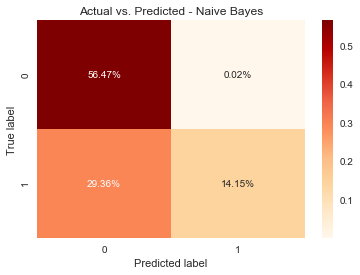

In [102]:
# In the final portion of the project, I'll build visualizations for the above confusion matrices.

# Using Seaborn's heat map, we can visualize the ability of the model to assess actual vs. predicted values.
conf_mat = confusion_matrix(y_test, nb_pred)
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, 
            fmt='.2%', cmap='OrRd')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Actual vs. Predicted - Naive Bayes')
print('Naive Bayes Confusion Matrix and Classification Report')
print('-----'*21)
print("Accuracy of Naive Bayes Classifier: {}%".format(round(accuracy_score(y_test, nb_pred)*100,2)))
print('-----'*21)
print(classification_report(y_test, nb_pred))

Accuracy of Linear Regression Classifier: 94.3%
---------------------------------------------------------------------------------------------------------
Classification Report
---------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3409
           1       0.95      0.92      0.93      2626

    accuracy                           0.94      6035
   macro avg       0.94      0.94      0.94      6035
weighted avg       0.94      0.94      0.94      6035



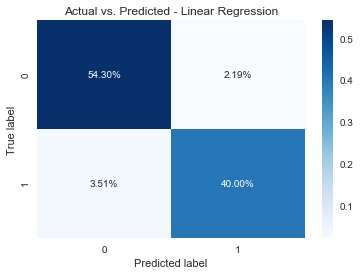

In [103]:
# I'll do the same for the linear regression prediction.

conf_mat_2 = confusion_matrix(y_test, lr_pred)
sns.heatmap(conf_mat_2/np.sum(conf_mat_2), annot=True, 
            fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Actual vs. Predicted - Linear Regression')
print("Accuracy of Linear Regression Classifier: {}%".format(round(accuracy_score(y_test, lr_pred)*100,2)))
print('-----'*21)
print('Classification Report')
print('-----'*21)
print(classification_report(y_test, lr_pred))

Accuracy of Support Vector Machine: 96.22%
---------------------------------------------------------------------------------------------------------
Support Vector Machine Classification Report
---------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3409
           1       0.96      0.95      0.96      2626

    accuracy                           0.96      6035
   macro avg       0.96      0.96      0.96      6035
weighted avg       0.96      0.96      0.96      6035



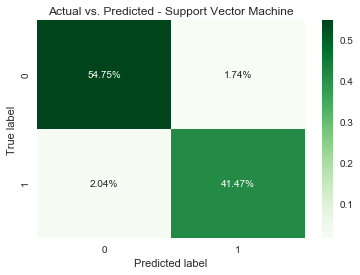

In [104]:
# And, finally, the support vector machine (linear kernel). 

conf_mat_3 = confusion_matrix(y_test, svc_pred)
sns.heatmap(conf_mat_3/np.sum(conf_mat_3), annot=True, 
            fmt='.2%', cmap='Greens')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Actual vs. Predicted - Support Vector Machine')
print("Accuracy of Support Vector Machine: {}%".format(round(accuracy_score(y_test, svc_pred)*100,2)))
print('-----'*21)
print('Support Vector Machine Classification Report')
print('-----'*21)
print(classification_report(y_test, svc_pred))

### Ultimately, I proved my null hypothesis although with an important caveat. Though, at first glance, it may appear that Naive Bayes received the lowest accuracy score, as I mentioned above, accuracy is not the best metric to assess a model's performance. It must be noted that even though Naive Bayes was only 70% accurate, its recall and precision scores were excellent, meaning that it could correctly classify values in either class. However, the most consistently high-performing model was the linear kernel Support Vector Machine which scored in the high 90s across all three categories: Precision, recall and f1-score. It is also worth noting that the performance of these classifiers could still vary greatly depending upon the stop words chosen, features filtered and hyper parameters entered. There is also little guarantee these methods would be effective on non-English language classification problems. However, this experiment determined that a Support Vector Machine is the most effective classifier for addressing an English language fake news detection problem.